In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import MaxNLocator
import ast

# Feature Importance (All_Cleaned)

In [28]:
def data_from_files_FI(relative_path):
    file_list_results = glob.glob(relative_path)
    features_sum = np.zeros((211,1))
    if 'lagged' in relative_path.lower():
        features_sum = np.zeros((275,1))

    for file in file_list_results:
        features_df = pd.read_csv(file)
        features_sum += features_df.values
    return features_sum / np.sum(features_sum) * 100 # Procent

In [34]:
def find_max_FI(features_importances, dataset_name):
    max_indices = np.argpartition(features_importances, -10, axis=0)[-10:]
    data = pd.read_csv(f'Data/{dataset_name}_data.csv') # Use same data to get right columns
    data = data.iloc[:,2:]
    print(f'Data features: {data.shape[1]}')
    print(f'Features from files: {features_importances.shape[0]}')
    max_features = data.columns.values[max_indices.flatten()]
    max_values = features_importances[max_indices.flatten()].flatten() 
    return max_features, max_values

In [35]:
def feature_importance_plot(feature_values, feature_names, dataset_name, model_name):
    x_values = np.arange(len(feature_values))
    plt.barh(x_values, feature_values)
    plt.yticks(x_values, feature_names, rotation=0, ha='right')
    plt.xlabel('Importances (%)')
    plt.title(f'Total Feature Importances for {model_name} on {dataset_name} data')
    plt.grid()
    plt.show()

In [36]:
def all_FI(dataset_name, model_names):
    for model_name in model_names:
        FI = data_from_files_FI(f'Results/Separate_Runs/{dataset_name}/{model_name}/*feature_importances365.csv')
        print(f'Check sum = 100%: {int(np.sum(FI))==100}')
        max_features, max_values = find_max_FI(FI, dataset_name)
        feature_importance_plot(max_values, max_features, dataset_name, model_name) 

Check sum = 100%: True
Data features: 275
Features from files: 275


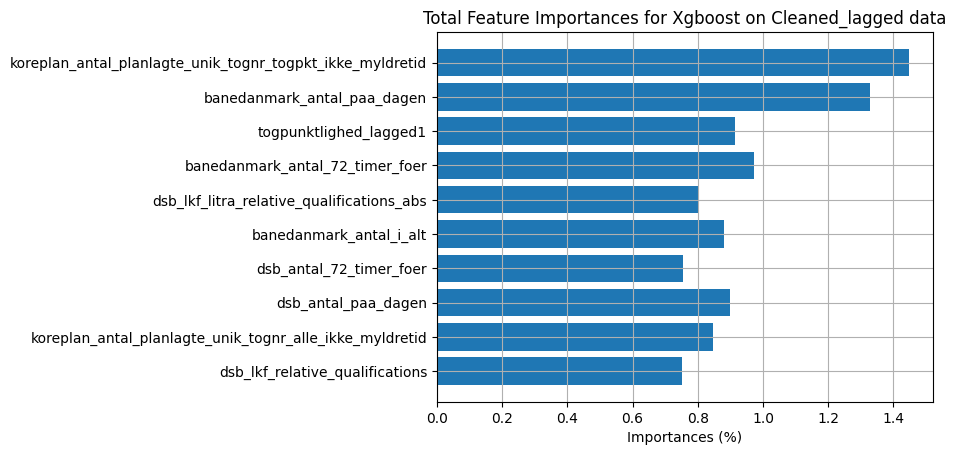

Check sum = 100%: True
Data features: 275
Features from files: 275


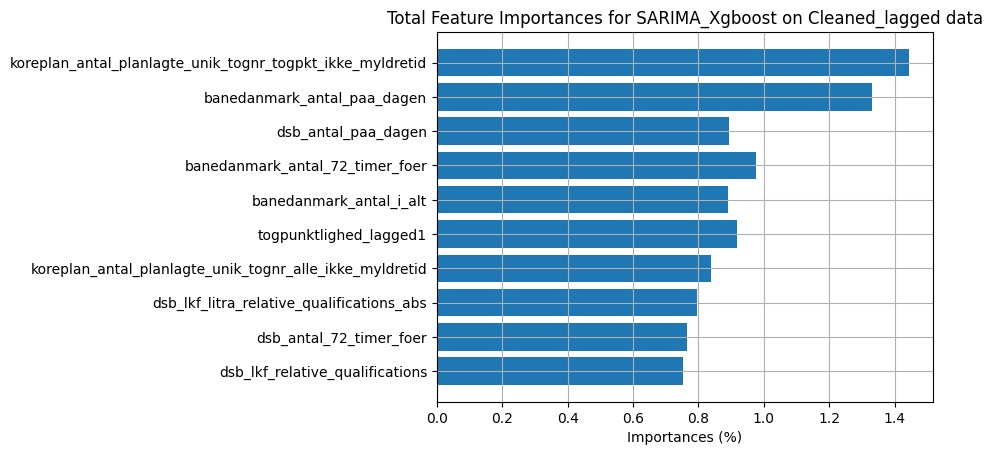

Check sum = 100%: True
Data features: 275
Features from files: 275


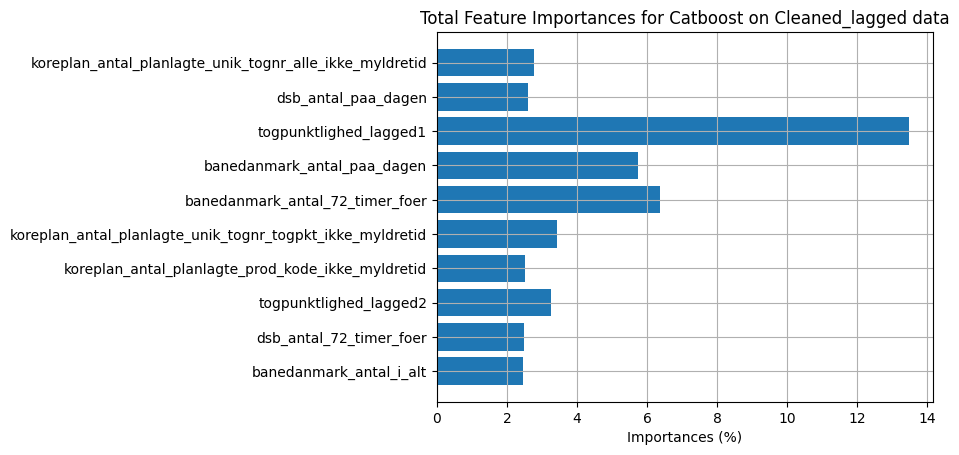

Check sum = 100%: False
Data features: 275
Features from files: 275


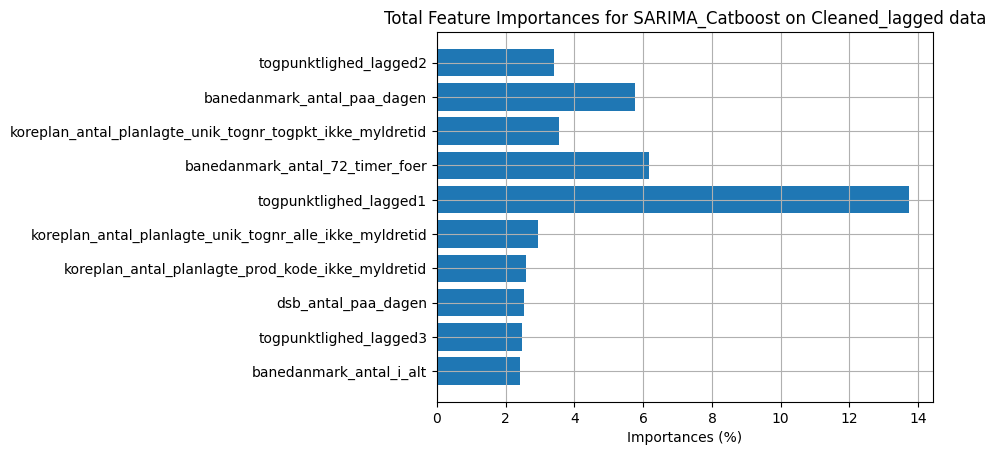

In [37]:
#all_FI('Cleaned', ['Xgboost', 'SARIMA_Xgboost', 'Catboost','SARIMA_Catboost'])
all_FI('Cleaned_lagged', ['Xgboost', 'SARIMA_Xgboost', 'Catboost','SARIMA_Catboost'])
# Not interesting to see together.

# Error (All on Cleaned.csv)

In [67]:
def data_from_files_error(relative_path):
    file_list_results = glob.glob(relative_path)
    
    strækning_station = []
    errors_baseline = []
    errors_arima = []
    errors_full = []

    for file in file_list_results:
        index_start = len(relative_path.split('*')[0])
        strækning_station += [file[index_start:].split('_')[0]]
        results_df = pd.read_csv(file)
        errors_baseline += [results_df['Error_baseline'][0]]
        errors_arima += [results_df.get('Error_arima', [None])[0]] # No ARIMA column in only Boosted
        errors_full += [results_df['Error_full'][0]]
    
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_arima, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_arima', 'Errors_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_full'])

In [68]:
def extract_train_routes(specific_train_route, errors_df):
    return errors_df[errors_df['route_station'].str.startswith(f'({specific_train_route},')]

In [69]:
def error_plot(df):
    df = df.sort_values(by='route_station')

    bar_width = 0.25
    index = range(len(df))
    # Plot baseline errors
    plt.bar(index, df['Errors_baseline'], bar_width, label='Baseline')
    # Plot ARIMA errors if available
    displacement = 1
    if 'Errors_arima' in df.columns:
        plt.bar([i + bar_width for i in index], df['Errors_arima'], bar_width, label='ARIMA')
        displacement = 2
    # Plot full errors
    plt.bar([i + displacement*bar_width for i in index], df['Errors_full'], bar_width, label='Full')

    plt.xlabel('(Strækning, Station)')
    plt.ylabel('Error')
    plt.title('Error comparison for (Strækning, Station) pairs')

    if displacement == 1:
        plt.xticks([i + bar_width/2 for i in index], df['route_station'])
    else: plt.xticks([i + bar_width for i in index], df['route_station'])

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [70]:
def error_function(dataset_name, model_name, specific_train_route=0, use_mean=False):
    errors_df = data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')
    if use_mean:
        mean_errors = pd.DataFrame(errors_df.mean(axis=0, numeric_only=True)).T
        mean_errors = mean_errors.assign(route_station='Mean')
        error_plot(mean_errors)
    else:
        errors_specific_route = extract_train_routes(specific_train_route, errors_df)
        error_plot(errors_specific_route)

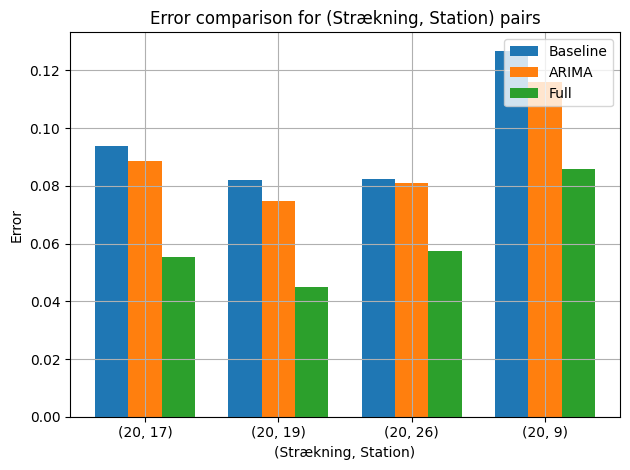

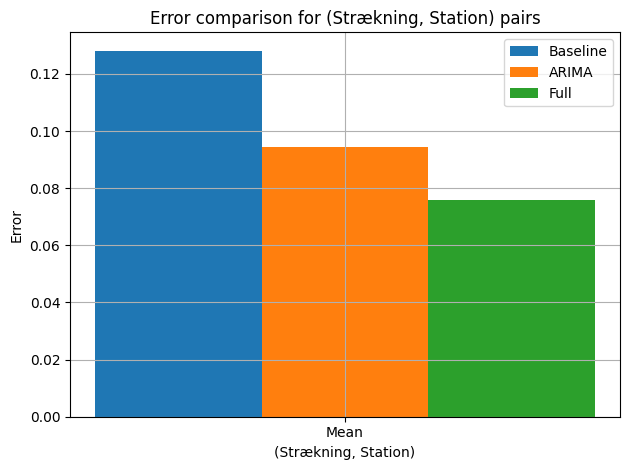

In [71]:
error_function('Cleaned', 'SARIMA_Xgboost', 20)

error_function('Cleaned', 'SARIMA_Xgboost', use_mean=True)

In [86]:
def data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean):
    data = []
    for model_name in model_names:
        dataset =  data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')
        if use_mean:
            data += [pd.DataFrame(dataset.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')]
        else:
            data += [extract_train_routes(specific_train_route, dataset)]
    return data

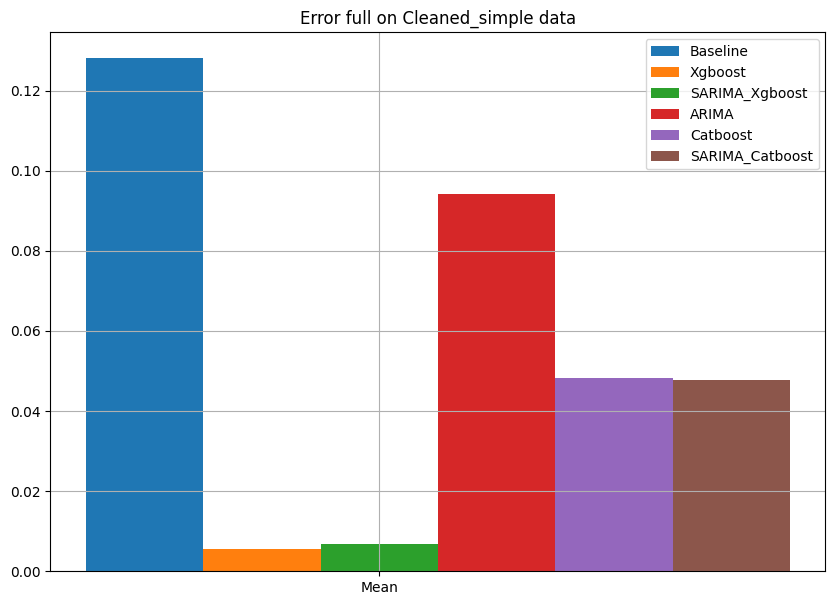

In [96]:
# Plot same columns across models/datasets

def plot_columns(model_names, dataset_name, specific_train_route, column, column_arima=None, use_mean=False):
    datasets = data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean)
    plt.figure(figsize=(10,7))
    bar_width = 0.15
    index = range(len(datasets[0]))
    arima_found=False
    plt.bar([j + bar_width for j in index], datasets[0]['Errors_baseline'], bar_width, label='Baseline')
    counter = 0
    for i, (name, dataset) in enumerate(zip(model_names, datasets)):
        dataset = dataset.sort_values(by='route_station')
        plt.bar([j + (counter+2) * bar_width for j in index], dataset[column].values, bar_width, label=name)
        counter += 1
        if column_arima in dataset.columns and not arima_found:
            plt.bar([j + (counter+2) * bar_width for j in index], dataset[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([i + 3 * bar_width for i in index], datasets[0]['route_station'])
        #print(dataset)
    
    plt.legend()
    plt.title(f'Error full on {dataset_name} data')
    plt.grid()

plot_columns(['Xgboost', 'SARIMA_Xgboost', 'Catboost', 'SARIMA_Catboost'], 'Cleaned_simple', 20, 'Errors_full', column_arima='Errors_arima', use_mean=True)

# CV scores

In [88]:
def data_from_files_CV(relative_path):
    file_list_results = glob.glob(relative_path)
    index_start = len(relative_path.split('*')[0])

    strækning_station =[]
    cv_full = []
    cv_arima = []
    cv_baseline = []

    for file in file_list_results:
        results_df = pd.read_csv(file)
        strækning_station += [file[index_start:].split('_')[0]]
        cv_full += [results_df['CV_score_full']]
        cv_arima += [results_df.get('CV_score_arima', [None])]
        cv_baseline += [results_df['CV_score_baseline']]
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, cv_baseline, cv_arima, cv_full)), columns=['route_station', 'CV_baseline', 'CV_arima', 'CV_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, cv_baseline, cv_full)), columns=['route_station', 'CV_baseline', 'CV_full'])

In [90]:
SARIMA_Xgboost_CV = data_from_files_CV('Results/Separate_Runs/SARIMA_Xgboost/*results365.csv')#['Errors_baseline'][0]

In [92]:
SARIMA_Xgboost_CV20 = extract_train_routes(20, SARIMA_Xgboost_CV)

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def hist_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    max_score = max(max(cv_scores_baseline), max(cv_scores_full))
    min_score = min(min(cv_scores_baseline), min(cv_scores_full))
    
    arima_check = not cv_scores_arima.isnull().all()

    if arima_check:
        max_score = max(max_score, max(cv_scores_arima))
        min_score = min(min_score, min(cv_scores_arima))
    
    num_bins = 15
    bins = np.linspace(min_score, max_score, num_bins)
    
    plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.5, label='Baseline')
    
    if arima_check:
        plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.5, label='ARIMA')
    
    plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.5, label='Full')

    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('MAE')
    plt.ylabel('Occurrences')
    plt.legend(loc='upper right')
    plt.grid()
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
    plt.show()

def linechart_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    plt.plot(cv_scores_baseline, label='Baseline')
    
    if not cv_scores_arima.isnull().all():
        plt.plot(cv_scores_arima, label='ARIMA')

    plt.plot(cv_scores_full, label='Full')
    
    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('Data points')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

def plot_cv_scores(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    hist_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima)
    linechart_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima)

In [ ]:
def cv_function(dataset_name, model_name, specific_train_route):
    cv_scores = data_from_files_CV('Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')#['Errors_baseline'][0]
    cv_scores_specific_route = extract_train_routes(specific_train_route, cv_scores)
    plot_cv_scores(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None)

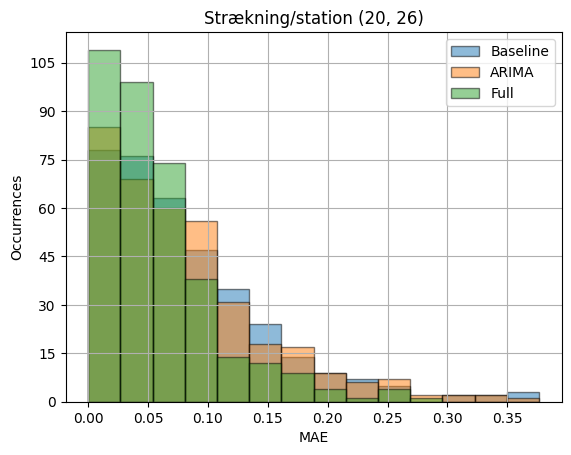

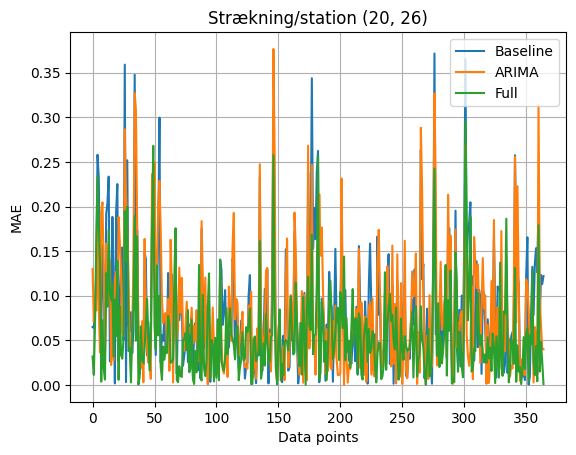

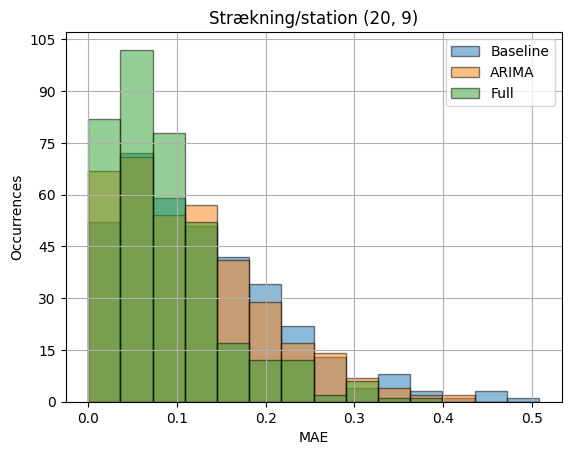

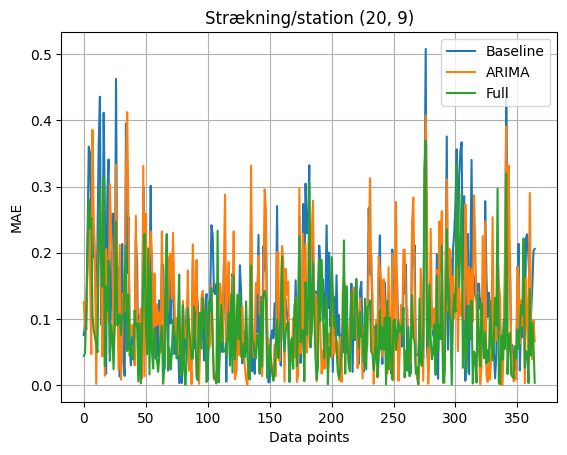

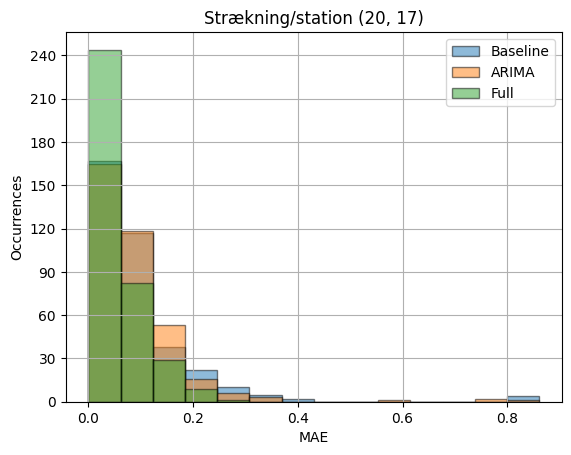

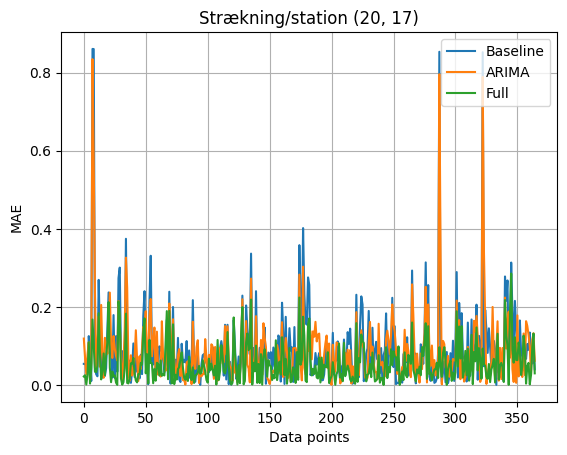

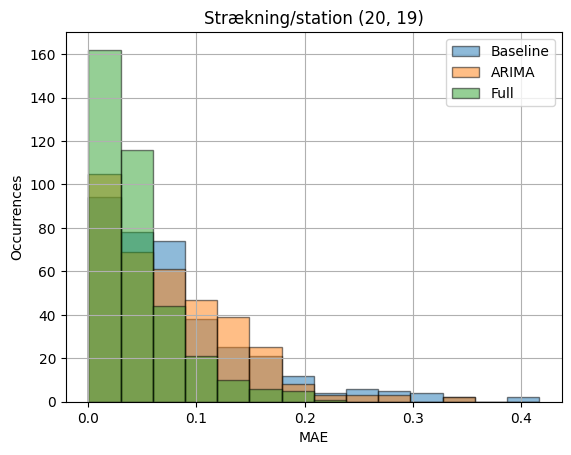

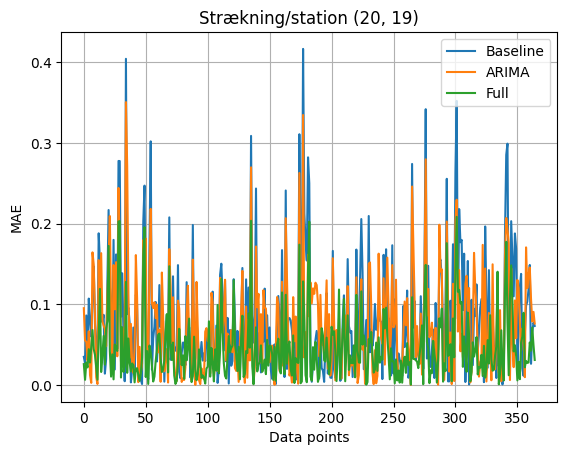

In [119]:
for row_no, row in SARIMA_Xgboost_CV20.iterrows():
    plot_cv_scores(row['route_station'], row['CV_full'], row['CV_baseline'], cv_scores_arima=row.get('CV_arima', [None]))

# Predictions

In [153]:
def data_from_files_pred(relative_path):
    file_list_results = glob.glob(relative_path)
    index_start = len(relative_path.split('*')[0])

    strækning_station =[]
    y_true = []
    pred_full = []
    pred_arima = []
    pred_baseline = []

    for file in file_list_results:
        results_df = pd.read_csv(file)
        strækning_station += [file[index_start:].split('_')[0]]
        y_true += [results_df['y_true']]
        pred_full += [results_df['Predictions_full']]
        pred_arima += [results_df.get('Predictions_arima', [None])]
        pred_baseline += [results_df['Predictions_baseline']]
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, y_true, pred_baseline, pred_arima, pred_full)), columns=['route_station', 'y_true', 'Predictions_baseline', 'Predictions_arima', 'Predictions_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, y_true, pred_baseline, pred_full)), columns=['route_station', 'y_true', 'Predictions_baseline', 'Predictions_full'])

In [154]:
Xgboost_pred = data_from_files_pred('Results/Separate_Runs/Xgboost/*results365.csv')
SARIMA_Xgboost_pred = data_from_files_pred('Results/Separate_Runs/SARIMA_Xgboost/*results365.csv')

In [155]:
Xgboost_pred20 = extract_train_routes(20, Xgboost_pred)
SARIMA_Xgboost_pred20 = extract_train_routes(20, SARIMA_Xgboost_pred)

In [178]:
def plot_preds(filtered_df, initial_start, arima=False):
    initial_start = initial_start
    for row_no, row in filtered_df.iterrows():
        y_test = row['y_true']
        # Extract corresponding predictions from predictions DataFrame
        predictions_arima = row.get('Predictions_arima', [None])
        predictions_full = row['Predictions_full']
        # Dates: 
        x_dates = predictions_full.index
        route_station = row['route_station']
        plt.plot(x_dates[-initial_start:], y_test[-initial_start:], color='#33a02c', label='Test Data')
        if arima:
            predictions_arima = row.get('Predictions_arima', [None])
            plt.plot(x_dates[-initial_start:], predictions_arima[-initial_start:], color='#1E77B4', marker='x', label='ARIMA Predictions')
        plt.plot(x_dates[-initial_start:], predictions_full[-initial_start:], color='#FD7E0E', marker='x', label='Full Predictions')
        plt.title(f'Route/station {route_station}: Predictions & True Value')
        plt.xlabel('Observations')
        plt.ylabel('Train punctuality')
        plt.xticks(x_dates[-initial_start::10], rotation=45)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

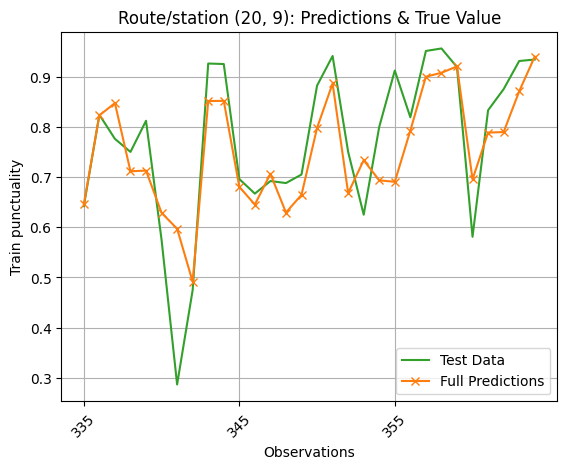

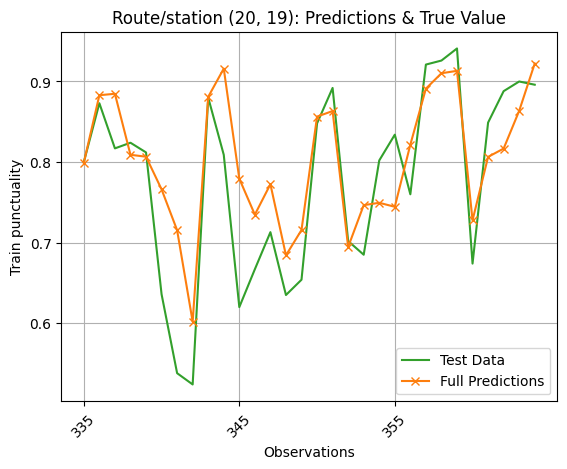

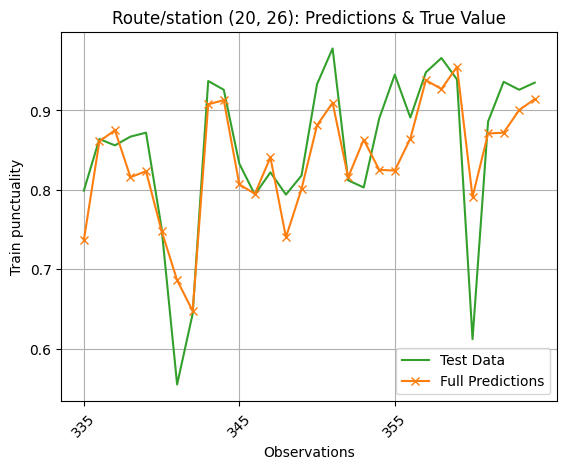

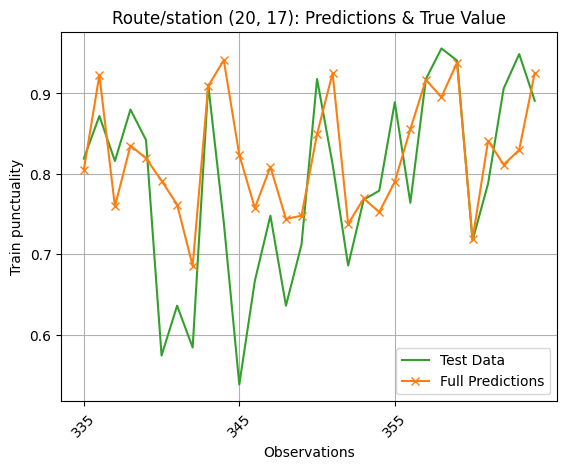

In [179]:
plot_preds(Xgboost_pred20, 30)

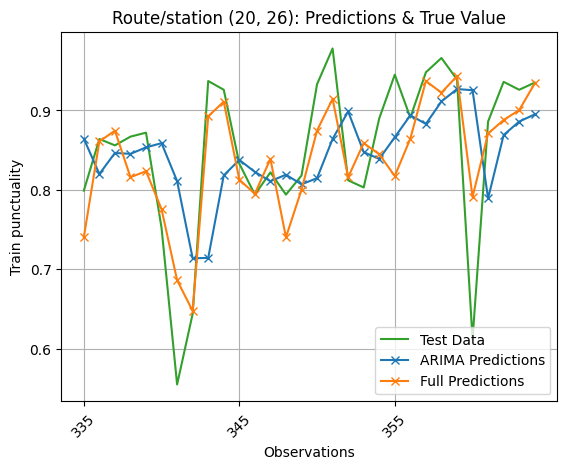

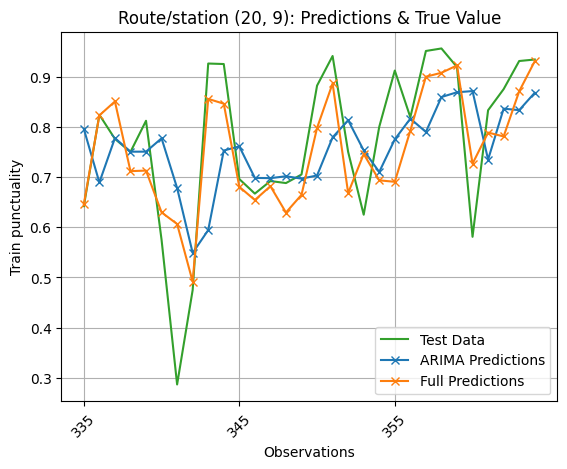

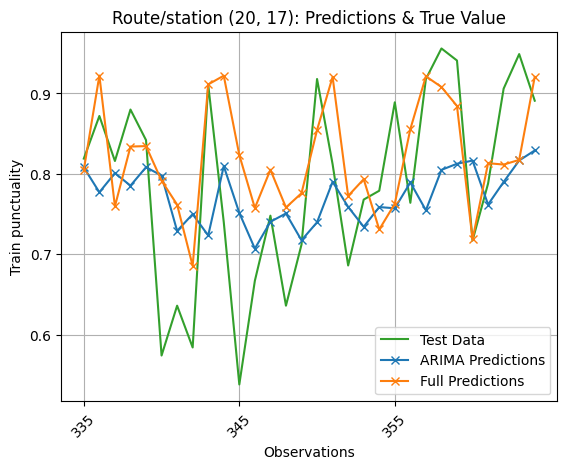

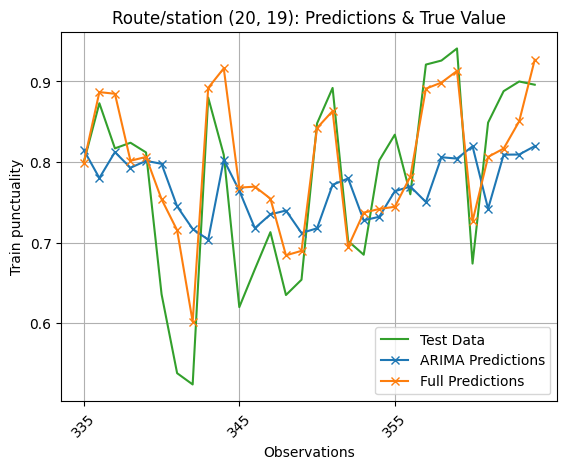

In [181]:
plot_preds(SARIMA_Xgboost_pred20, 30, arima=True)